# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize, basinhopping
from scipy.stats import norm
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 34115,
  "iopub_port": 51479,
  "stdin_port": 42359,
  "control_port": 36725,
  "hb_port": 57631,
  "ip": "127.0.0.1",
  "key": "bcae70a1-1a267fa64a4e9c3f901aa1c3",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-b736e99f-e16d-4c40-adcc-3d796a87ce27.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/updated_e_sf/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'mumu',  
              'emu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.01)
params = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()

In [3]:
# generate scan points
beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                [(0.104, 0.118), (0.104, 0.118), (0.104, 0.118)], 
                                [5, 5, 5]
                                )
scan_vals = np.array(beta_scan_vals.get_scan_vals()[0])
beta_h = np.transpose([1 - np.sum(scan_vals, axis=1)])
scan_vals = np.hstack((scan_vals, beta_h, np.outer(np.ones(scan_vals.shape[0]), params_pre[4:])))

In [4]:
# carry out the scan #

# minimizer options
min_options = dict(
                   #eps=1e-10,
                   gtol=1e-2, 
                   disp=True
                  )

results = []
cost = []
sv_accept = []
pinit = params_pre[fit_data._pmask]
mask = fit_data._pmask.copy()
for sv in tqdm_notebook(scan_vals):
    
    # randomize n.p.
    mask[:4] = False
    np_random = params_pre[mask] + fit_data._perr_init[mask]*np.random.randn(mask.sum())
    fit_data._pval_init[mask] = np_random
    #sv[mask] = np_random
    mask[:4] = True
    
    # generate data from scan values w/ statistical variation
    sample = dict()
    for category in fit_data._categories:
        val, var = fit_data.mixture_model(sv, category)
        sample[category] = [np.random.poisson(val), val]

    # carry out minimization
    result = minimize(fit_data.objective, pinit,
                      method  = 'BFGS', 
                      options = min_options,
                      jac     = fit_data.objective_jacobian,
                      args    = (sample)
                     )
    print(' ', result.success, fit_data.objective(pinit), fit_data.objective(sv[mask]), result.fun)
    #print(' jacobian: ', result.jac)
    #print(' init vals: ', pinit)
    #print(' nps: ', np_random)
    print(' scan vals: ', sv[:4])
    print(' fit vals:', result.x[:4], end='\n\n')

    results.append(result.x)
    cost.append(result.fun)
    sv_accept.append(sv[mask])
    

         Current function value: 107.411844
         Iterations: 70
         Function evaluations: 147
         Gradient evaluations: 137
  False 1215.0176524446742 1573.7008385264364 107.41184410422494
 scan vals:  [0.104 0.104 0.104 0.688]
 fit vals: [0.1027 0.1035 0.1024 0.6914]

         Current function value: 118.248524
         Iterations: 85
         Function evaluations: 159
         Gradient evaluations: 148
  False 1214.2740788810117 1477.795385901263 118.24852392897209
 scan vals:  [0.104  0.104  0.1075 0.6845]
 fit vals: [0.104  0.1037 0.1076 0.6847]

         Current function value: 115.860543
         Iterations: 66
         Function evaluations: 146
         Gradient evaluations: 134
  False 1214.950146893316 1410.3847227076187 115.86054310218755
 scan vals:  [0.104 0.104 0.111 0.681]
 fit vals: [0.102  0.1029 0.1079 0.6872]

         Current function value: 117.442301
         Iterations: 73
         Function evaluations: 116
         Gradient evaluations: 104
  False 

         Current function value: 109.313119
         Iterations: 68
         Function evaluations: 139
         Gradient evaluations: 128
  False 1200.4209698036511 6386.903754996473 109.31311877899219
 scan vals:  [0.104  0.118  0.1145 0.6635]
 fit vals: [0.1042 0.1187 0.1188 0.6582]

         Current function value: 127.521973
         Iterations: 70
         Function evaluations: 122
         Gradient evaluations: 112
  False 1210.2616636669484 6517.80826833691 127.52197283859894
 scan vals:  [0.104 0.118 0.118 0.66 ]
 fit vals: [0.105  0.1184 0.1212 0.6553]

         Current function value: 122.713319
         Iterations: 75
         Function evaluations: 123
         Gradient evaluations: 113
  False 1213.182669137428 1217.7881604405559 122.7133190829234
 scan vals:  [0.1075 0.104  0.104  0.6845]
 fit vals: [0.1086 0.1044 0.1037 0.6833]

         Current function value: 127.586876
         Iterations: 69
         Function evaluations: 176
         Gradient evaluations: 164
  False

         Current function value: 128.600686
         Iterations: 75
         Function evaluations: 148
         Gradient evaluations: 137
  False 1224.0002903412146 6219.074106127673 128.60068556201364
 scan vals:  [0.1075 0.118  0.1075 0.667 ]
 fit vals: [0.1068 0.1185 0.1039 0.6708]

         Current function value: 126.612006
         Iterations: 75
         Function evaluations: 147
         Gradient evaluations: 135
  False 1209.9648035391326 6305.090220382628 126.61200646776429
 scan vals:  [0.1075 0.118  0.111  0.6635]
 fit vals: [0.1079 0.1181 0.1118 0.6622]

         Current function value: 112.585348
         Iterations: 78
         Function evaluations: 168
         Gradient evaluations: 156
  False 1197.4075228405259 6419.466523021237 112.5853475415314
 scan vals:  [0.1075 0.118  0.1145 0.66  ]
 fit vals: [0.1067 0.1176 0.1166 0.6591]

         Current function value: 138.447322
         Iterations: 69
         Function evaluations: 148
         Gradient evaluations: 137
  

         Current function value: 124.540445
         Iterations: 72
         Function evaluations: 142
         Gradient evaluations: 130
  False 1216.1848279508313 4627.103080833708 124.5404450991679
 scan vals:  [0.111  0.1145 0.118  0.6565]
 fit vals: [0.1113 0.1131 0.1146 0.661 ]

         Current function value: 117.193264
         Iterations: 80
         Function evaluations: 159
         Gradient evaluations: 147
  False 1209.772397209677 6733.495500361867 117.19326383056608
 scan vals:  [0.111 0.118 0.104 0.667]
 fit vals: [0.11   0.1168 0.1025 0.6707]

         Current function value: 130.602971
         Iterations: 89
         Function evaluations: 188
         Gradient evaluations: 177
  False 1210.573925849408 6837.1138139107115 130.60297100512426
 scan vals:  [0.111  0.118  0.1075 0.6635]
 fit vals: [0.1104 0.1181 0.1078 0.6637]

         Current function value: 121.492779
         Iterations: 77
         Function evaluations: 125
         Gradient evaluations: 113
  False

         Current function value: 106.245860
         Iterations: 85
         Function evaluations: 197
         Gradient evaluations: 185
  False 1199.6456422870506 5539.058488930791 106.24585982041508
 scan vals:  [0.1145 0.1145 0.111  0.66  ]
 fit vals: [0.1155 0.1139 0.1154 0.6553]

         Current function value: 127.824248
         Iterations: 79
         Function evaluations: 171
         Gradient evaluations: 162
  False 1216.439149523624 5710.334390513417 127.82424817305679
 scan vals:  [0.1145 0.1145 0.1145 0.6565]
 fit vals: [0.1148 0.1145 0.1156 0.6551]

         Current function value: 121.558682
         Iterations: 83
         Function evaluations: 177
         Gradient evaluations: 166
  False 1201.7202888041002 5876.754293883028 121.55868237645846
 scan vals:  [0.1145 0.1145 0.118  0.653 ]
 fit vals: [0.1147 0.1145 0.1178 0.653 ]

         Current function value: 114.492126
         Iterations: 88
         Function evaluations: 183
         Gradient evaluations: 171
  

         Current function value: 126.048420
         Iterations: 97
         Function evaluations: 204
         Gradient evaluations: 192
  False 1214.111516462498 7079.36003619738 126.04842015047949
 scan vals:  [0.118  0.1145 0.104  0.6635]
 fit vals: [0.1178 0.1147 0.1039 0.6636]

         Current function value: 112.340438
         Iterations: 84
         Function evaluations: 166
         Gradient evaluations: 155
  False 1209.8799985400344 7201.160176502917 112.34043783859856
 scan vals:  [0.118  0.1145 0.1075 0.66  ]
 fit vals: [0.1189 0.1148 0.1093 0.6569]

         Current function value: 122.424948
         Iterations: 93
         Function evaluations: 182
         Gradient evaluations: 170
  False 1206.3202718608804 7351.242408912496 122.42494832498504
 scan vals:  [0.118  0.1145 0.111  0.6565]
 fit vals: [0.1173 0.1134 0.1111 0.6582]

         Current function value: 141.504240
         Iterations: 91
         Function evaluations: 138
         Gradient evaluations: 127
  F

In [5]:
#calculate biases
results = np.array(results)
sv_accept = np.array(sv_accept)
cost = np.array(cost)

diff = (results - sv_accept)
diff[:,:4] /= 0.01*pinit[:4]
#diff[:,:4] /= 0.01*sv_accept[:,:4]
diff[:,4:diff.shape[1]] /= params['err_init'][4:diff.shape[1]].values

#diff = np.array([d for d in diff if np.all((d > -10) & (d < 10))])

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


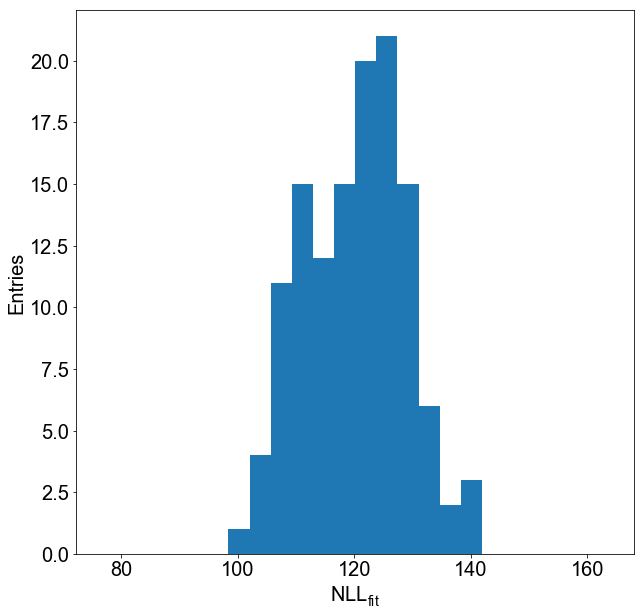

In [6]:
# plot the cost
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

cost = cost[cost<600]
cost_mean, cost_err = cost.mean(), cost.std()
ax.hist(cost, bins=np.linspace(np.max([0, cost_mean - 5*cost_err]), cost_mean + 5*cost_err, 25), histtype='stepfilled')
ax.set_xlabel(r'$NLL_{fit}$')
ax.set_ylabel('Entries')

plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


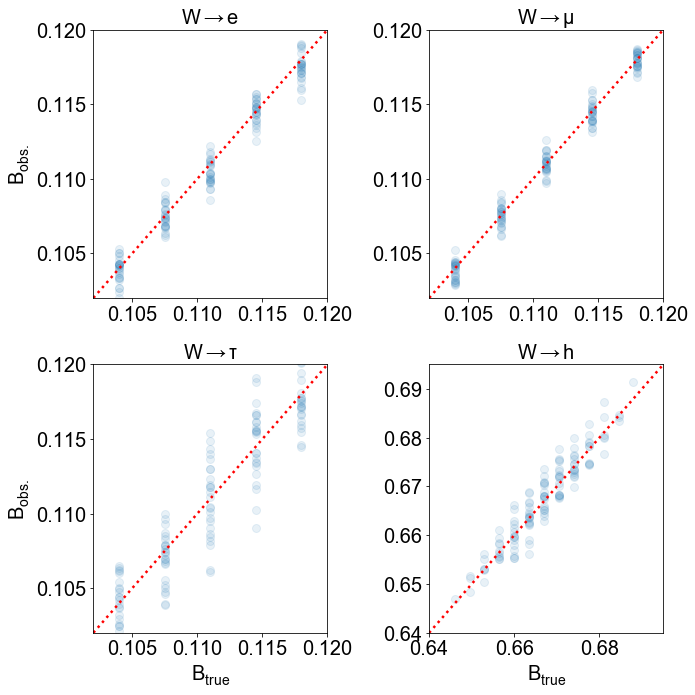

In [20]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=False, sharey=False)

beta_val = sv_accept[:,:4]
beta_obs = results[:,:4]

ax = axes[0][0]
ax.plot(beta_val[:,0], beta_obs[:,0], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
ax.plot(beta_val[:,1], beta_obs[:,1], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
ax.plot(beta_val[:,2], beta_obs[:,2], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
ax.plot(beta_val[:,3], beta_obs[:,3], 'C0o', alpha=0.1)
ax.plot([0.64, 0.72], [0.64, 0.72], 'r:')
ax.set_xlim(0.64, 0.695)
ax.set_ylim(0.64, 0.695)
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow h$', size=20)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_scan.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


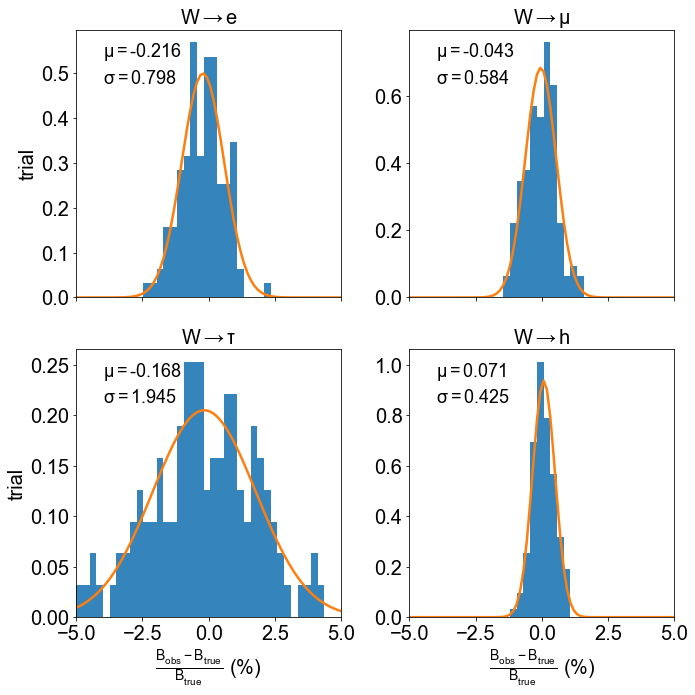

In [19]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=True, sharey=False)
bins = np.linspace(-5, 5, 80)

ax = axes[0][0]
dbeta = 100*(beta_obs[:,0] - beta_val[:,0])/beta_val[:,0]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_xlim(-5., 5.)
ax.set_ylim(0., None)
ax.set_ylabel('trial')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
dbeta = 100*(beta_obs[:,1] - beta_val[:,1])/beta_val[:,1]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
dbeta = 100*(beta_obs[:,2] - beta_val[:,2])/beta_val[:,2]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_ylabel('trial')
ax.set_xlabel(r'$\frac{B_{obs} - B_{true}}{B_{true}}$ (%)')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
dbeta = 100*(beta_obs[:,3] - beta_val[:,3])/beta_val[:,3]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_xlabel(r'$\frac{B_{obs} - B_{true}}{B_{true}}$ (%)')
ax.set_title(r'$W\rightarrow h$', size=20)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_bias.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


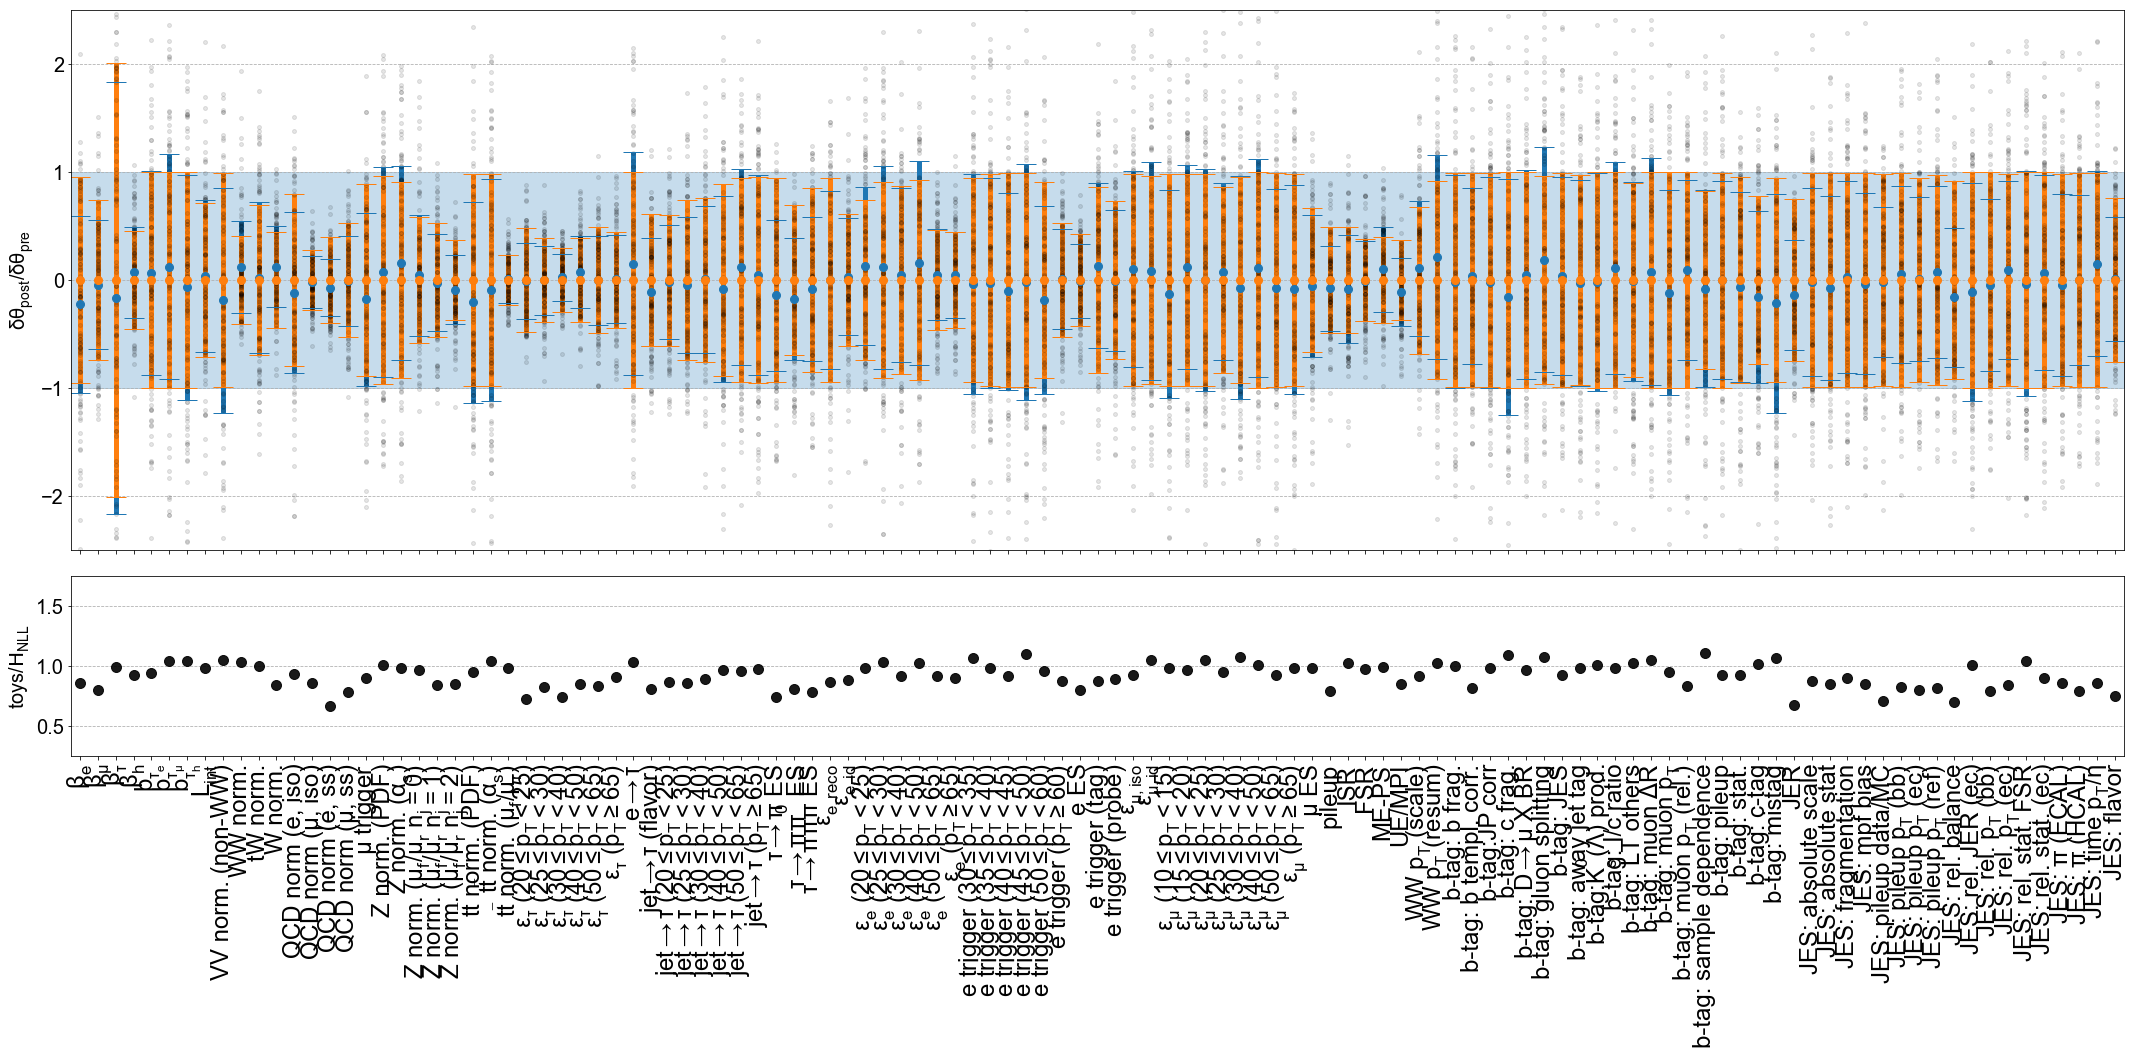

In [18]:
#plotting the results
fig, axes = plt.subplots(2, 1, figsize=(30, 15), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[3,1]})

df_pulls = pd.read_csv('local_data/pulls.csv').query('active == True')
df_pulls.loc[:3, 'ratio'] *= 100

nparams = params[mask].shape[0]
xticks = np.outer(np.arange(nparams), np.ones(diff.shape[0])).T
ax = axes[0]
ax.plot(xticks+1,  diff, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff.mean(axis=0), diff.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.errorbar(xticks[0]+1,  np.zeros(xticks[0].size), df_pulls['ratio'], fmt='C1o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)
#ax.boxplot(diff)

# extra dressing
ax.set_ylabel(r'$\delta\theta_{post}/\delta\theta_{pre}$')
ax.set_xlim(0.5, nparams+0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

ax = axes[1]
err_ratio = diff.std(axis=0)/df_pulls['ratio'].values
ax.plot(xticks[0]+1,  err_ratio, 'ko', alpha=0.9, markersize=10)
#ax.errorbar(xticks[0]+1,  diff.mean(axis=0), , fmt='C0o', capsize=10, elinewidth=5)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params[mask].label, size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'toys/$\mathcal{H}_{NLL}$')
ax.set_ylim(0.25, 1.75)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/new_pulls.pdf')
plt.show()

[0.8217 0.5963 2.002  0.4199]


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


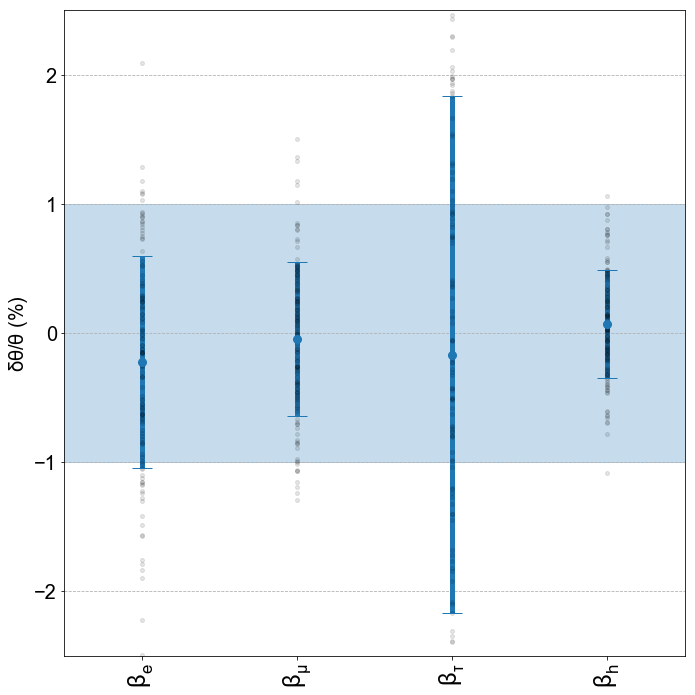

In [10]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

xticks = np.outer(np.arange(4), np.ones(diff.shape[0])).T
ax.plot(xticks+1,  diff[:,:4], 'ko', alpha=0.1, markersize=4)
#ax.boxplot(diff)
ax.errorbar(xticks[0,:4]+1,  diff[:,:4].mean(axis=0), diff[:,:4].std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

print(diff[:,:4].std(axis=0))

# extra dressing
ax.set_xticks(xticks[0,:4]+1)
ax.set_xticklabels(params.label[:4], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\delta\theta/\theta$ (%)')
ax.set_xlim(0.5, nparams+0.5)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


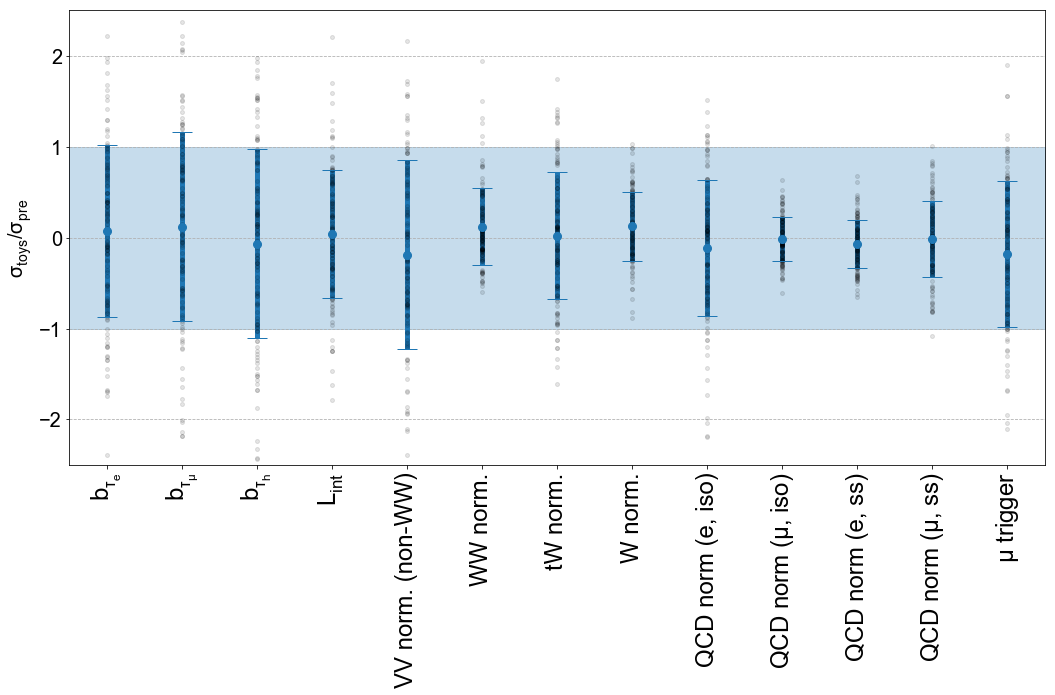

In [11]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor='white')

ip_low, ip_high = 4, 7 + fit_data._nnorm
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/norm_params.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


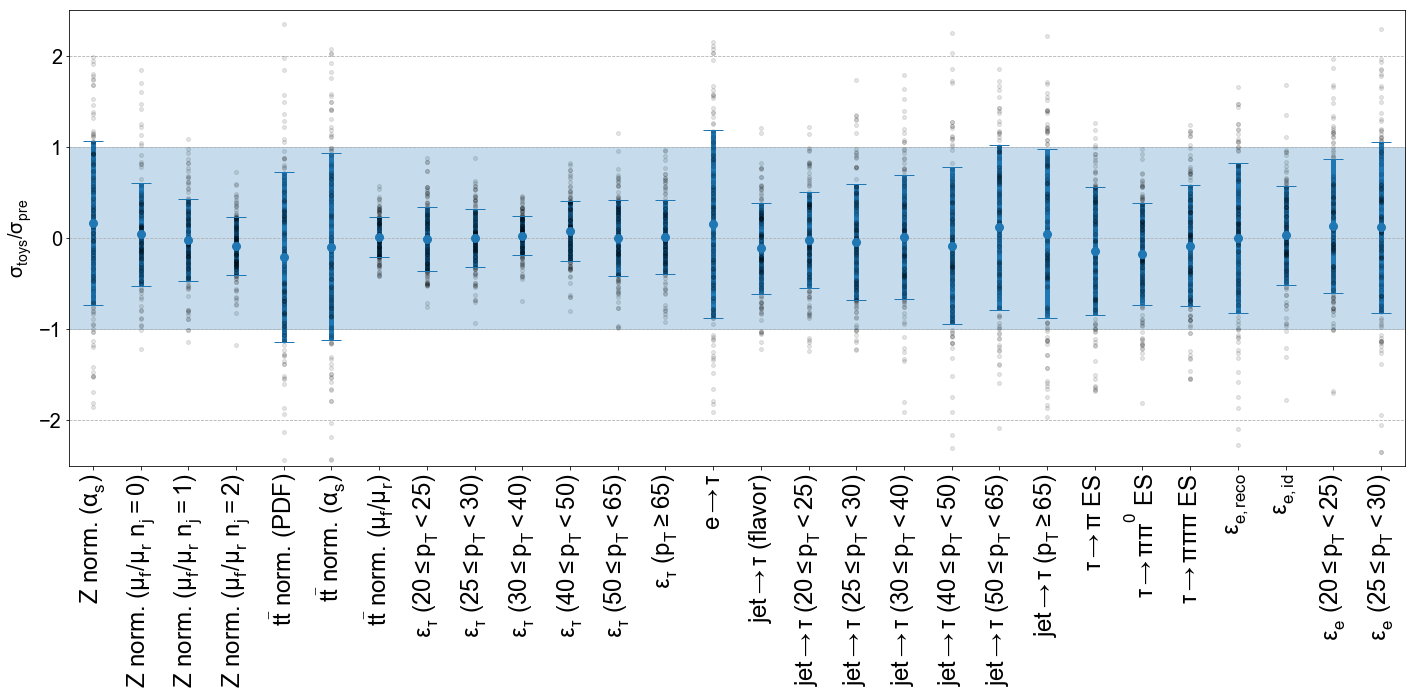

In [12]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 18, 46
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_reco_params.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


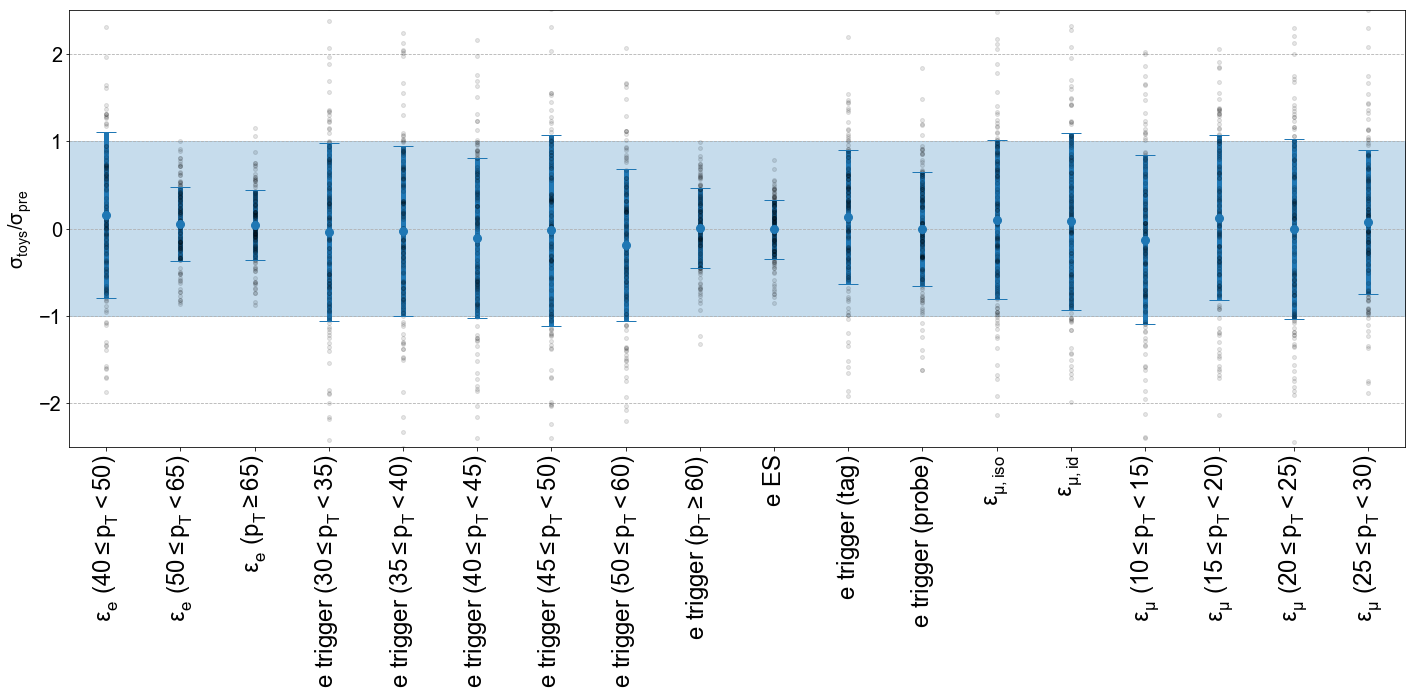

In [13]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 47, 65
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_btag_params.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


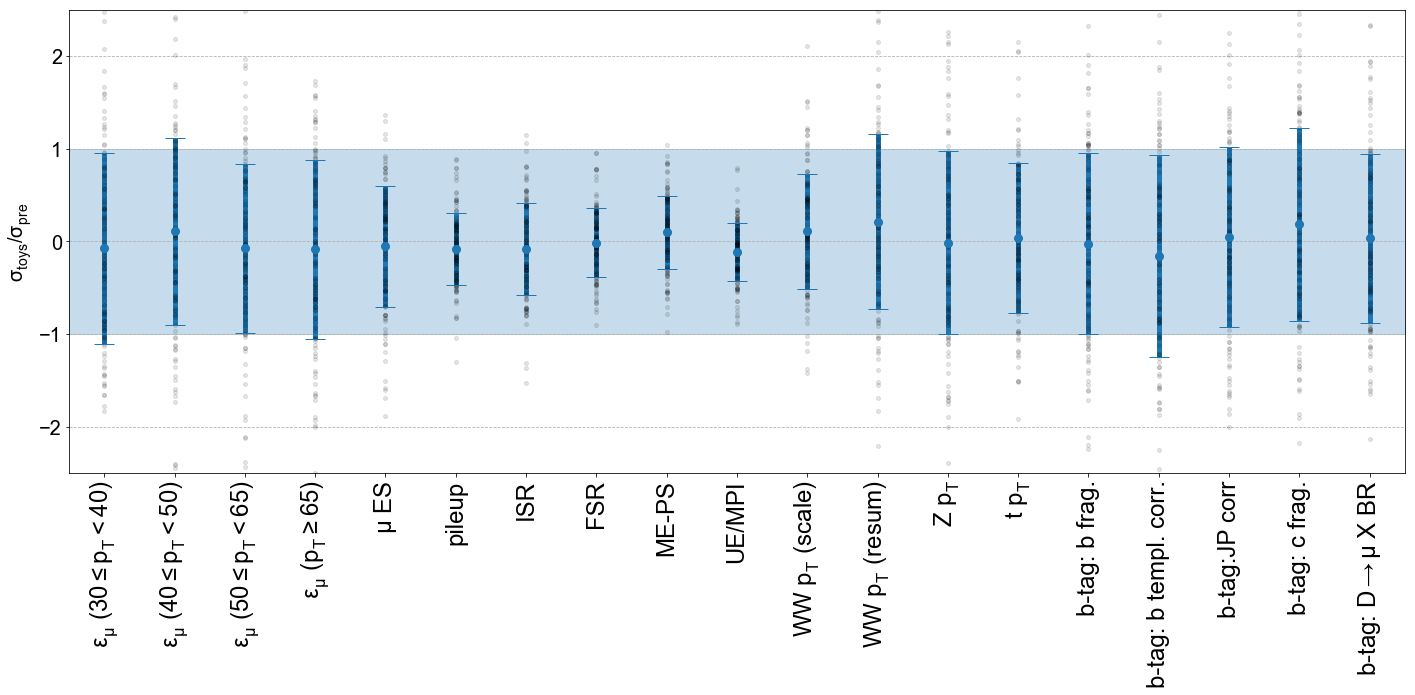

In [14]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 65, 84
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_jes_params.pdf')
plt.show()